In [1]:
%cd ..

/home/dmoreno/pipeline_v4_final/pipeline/training/stamp_classifier/models/experimentation/stamp_full


In [2]:
import os
import glob
import yaml
import pickle
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

from data_loader import get_tf_datasets

os.environ["CUDA_VISIBLE_DEVICES"] = 'MIG-802fb5a9-d98a-5bce-ad53-9227189dc2cf'

2025-06-06 08:46:07.614240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749199567.633360 2987733 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749199567.639252 2987733 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-06 08:46:07.659535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def evaluate_dataset(classifier, dataset):
    y_list = []
    predicted_probs_list = []
    images = []
    for X, pos, y in dataset:
        predicted_probs = tf.nn.softmax(classifier((X, pos)))
        y = y.numpy()
        y_list.append(y)
        predicted_probs_list.append(predicted_probs.numpy())
        images.append(X.numpy())
    predicted_probs = np.concatenate(predicted_probs_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    predictions = tf.argmax(predicted_probs, axis=1).numpy()
    return y, predicted_probs, predictions, images

# -----------------------

# EDITAR ESTA LISTA → puedes poner tantos paths como quieras
PATH_MODELS_LIST = glob.glob('results_incremental/*')
print('Number of experiments: ', len(PATH_MODELS_LIST))

# -----------------------

# Para guardar todos los resultados
global_results = {}

# Procesar cada experimento
for PATH_MODELS in PATH_MODELS_LIST:
    print(f"\n==========================")
    print(f"Processing experiment: {PATH_MODELS}")
    print(f"==========================")

    # Detectar las runs disponibles
    available_runs = sorted([d for d in os.listdir(PATH_MODELS) if d.startswith('run_') and os.path.isdir(os.path.join(PATH_MODELS, d))])

    print(f"Found runs: {available_runs}")

    # Si no hay runs, skip
    if len(available_runs) == 0:
        print(f"No runs found in {PATH_MODELS}, skipping.")
        continue

    # Diccionario para este experimento
    experiment_results = {}

    # Procesar cada run
    for run_dir in available_runs:
        print(f"\nProcessing {run_dir}...")

        run_path = os.path.join(PATH_MODELS, run_dir)

        # Cargar el config_used.pkl
        config_path = os.path.join(run_path, 'config_used.yaml')
        if not os.path.exists(config_path):
            print(f"Warning: {config_path} not found, skipping {run_dir}")
            continue

        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)

        hp_model = config['hp_model']
        args_general = config['args_general']

        print(f"Loaded config: {config_path}")

        # Cargar path_data desde config
        path_data = args_general['path_data']

        # Cargar LabelEncoder
        normalized_ndarrays = pd.read_pickle(path_data)
        LabelEncoder = normalized_ndarrays['label_encoder']
        del normalized_ndarrays

        # Cargar test_dataset con los args correctos
        with tf.device('/cpu:0'):
            _, _, test_dataset, dict_info_model = get_tf_datasets(
                batch_size=hp_model['batch_size'],
                args_general=args_general
            )

        # Encontrar el modelo .keras → buscar archivo que empiece con model_ y termine con .keras
        keras_model_files = [f for f in os.listdir(run_path) if f.startswith('model_') and f.endswith('.keras')]
        if len(keras_model_files) == 0:
            print(f"Warning: No .keras model found in {run_path}, skipping {run_dir}")
            continue

        keras_model_file = keras_model_files[0]  # tomar el primero
        keras_model_path = os.path.join(run_path, keras_model_file)

        print(f"Loading model: {keras_model_file}")

        # 🚀 EXTRAER EL NOMBRE DEL MODELO (para usar como key)
        model_name = keras_model_file.replace('model_', '').replace('.keras', '')
        print(f"Model name to be used in global_results: {model_name}")

        # Cargar el modelo
        stamp_classifier = tf.keras.models.load_model(keras_model_path)

        # Evaluar
        y_test, test_predicted_probs, test_predictions, images_test = evaluate_dataset(stamp_classifier, test_dataset)

        y_test_labels = LabelEncoder.inverse_transform(y_test)
        test_predictions_labels = LabelEncoder.inverse_transform(test_predictions)

        # Matriz de confusión
        conf_matrix = confusion_matrix(
            y_test_labels, test_predictions_labels,
            labels=LabelEncoder.classes_,
            normalize='true'
        )

        # Classification report
        report = classification_report(y_test_labels, test_predictions_labels, output_dict=True)

        # Guardar resultados para esta run
        experiment_results[run_dir] = {
            'model_name': model_name,
            'conf_matrix': conf_matrix,
            'classification_report': report,
            'y_test': y_test_labels,
            'y_pred': test_predictions_labels,
            'classes': LabelEncoder.classes_
        }

        print(f"Run {run_dir} finished.")

    # Guardar los resultados de este experimento
    global_results[PATH_MODELS] = experiment_results

# Guardar todos los resultados
output_file = 'inference_global_results.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(global_results, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"\nALL EXPERIMENTS PROCESSED.")
print(f"Global results saved to: {output_file}")

Number of experiments:  12

Processing experiment: results_incremental/2025-06-06_08-22-13
Found runs: ['run_0']

Processing run_0...
Loaded config: results_incremental/2025-06-06_08-22-13/run_0/config_used.yaml


I0000 00:00:1749199578.185024 2987733 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18030 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:82:00.0, compute capability: 8.0



Processing Features...
Metadata columns: ['chinr', 'classtar', 'dec', 'diffmaglim', 'distpsnr1', 'distpsnr2', 'distpsnr3', 'ecl_lat', 'ecl_long', 'fwhm', 'gal_b', 'gal_l', 'isdiffpos', 'magpsf', 'ncovhist', 'ndethist', 'non_detections', 'ra', 'sgscore1', 'sgscore2', 'sgscore3', 'sharpnr', 'sigmapsf']
Metadata train: (29109, 23)
Metadata val: (9703, 23)
Metadata test: (9704, 23)

Stamps train: (29109, 63, 63, 6)
Stamps val: (9703, 63, 63, 6)
Stamps test: (9704, 63, 63, 6)
Stamps train: (29109,)
Stamps val: (9703,)
Stamps test: (9704,)

Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.
Loading model: model_modified_md_focal_bn_crop_crop.keras
Model name to be used in global_results: modified_md_focal_bn_crop_crop


I0000 00:00:1749199591.168990 2987733 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-06 08:46:37.562697: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Run run_0 finished.

Processing experiment: results_incremental/2025-06-06_08-33-39
Found runs: ['run_0']

Processing run_0...
Loaded config: results_incremental/2025-06-06_08-33-39/run_0/config_used.yaml

Processing Features...
Metadata columns: ['chinr', 'classtar', 'dec', 'diffmaglim', 'distpsnr1', 'distpsnr2', 'distpsnr3', 'ecl_lat', 'ecl_long', 'fwhm', 'gal_b', 'gal_l', 'isdiffpos', 'magpsf', 'ncovhist', 'ndethist', 'non_detections', 'ra', 'sgscore1', 'sgscore2', 'sgscore3', 'sharpnr', 'sigmapsf']
Metadata train: (29109, 23)
Metadata val: (9703, 23)
Metadata test: (9704, 23)

Stamps train: (29109, 63, 63, 6)
Stamps val: (9703, 63, 63, 6)
Stamps test: (9704, 63, 63, 6)
Stamps train: (29109,)
Stamps val: (9703,)
Stamps test: (9704,)

Loading model: model_modified_md_focal_bn_crop_crop.keras
Model name to be used in global_results: modified_md_focal_bn_crop_crop


2025-06-06 08:47:01.198323: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Run run_0 finished.

Processing experiment: results_incremental/2025-06-06_07-38-05
Found runs: ['run_0']

Processing run_0...
Loaded config: results_incremental/2025-06-06_07-38-05/run_0/config_used.yaml

Processing Features...
Metadata columns: ['chinr', 'classtar', 'dec', 'diffmaglim', 'distpsnr1', 'distpsnr2', 'distpsnr3', 'ecl_lat', 'ecl_long', 'fwhm', 'gal_b', 'gal_l', 'isdiffpos', 'magpsf', 'ncovhist', 'ndethist', 'non_detections', 'ra', 'sgscore1', 'sgscore2', 'sgscore3', 'sharpnr', 'sigmapsf']
Metadata train: (29586, 23)
Metadata val: (9862, 23)
Metadata test: (9862, 23)

Stamps train: (29586, 63, 63, 6)
Stamps val: (9862, 63, 63, 6)
Stamps test: (9862, 63, 63, 6)
Stamps train: (29586,)
Stamps val: (9862,)
Stamps test: (9862,)

Loading model: model_modified_md_focal_bn_crop.keras
Model name to be used in global_results: modified_md_focal_bn_crop
Run run_0 finished.

Processing experiment: results_incremental/2025-06-06_07-10-02
Found runs: ['run_0']

Processing run_0...
Loaded

2025-06-06 08:47:50.728477: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Run run_0 finished.

Processing experiment: results_incremental/2025-06-06_06-53-00
Found runs: ['run_0']

Processing run_0...
Loaded config: results_incremental/2025-06-06_06-53-00/run_0/config_used.yaml

Processing Features...
Metadata columns: ['chinr', 'classtar', 'dec', 'diffmaglim', 'distpsnr1', 'distpsnr2', 'distpsnr3', 'ecl_lat', 'ecl_long', 'fwhm', 'gal_b', 'gal_l', 'isdiffpos', 'magpsf', 'ncovhist', 'ndethist', 'non_detections', 'ra', 'sgscore1', 'sgscore2', 'sgscore3', 'sharpnr', 'sigmapsf']
Metadata train: (29586, 23)
Metadata val: (9862, 23)
Metadata test: (9862, 23)

Stamps train: (29586, 63, 63, 6)
Stamps val: (9862, 63, 63, 6)
Stamps test: (9862, 63, 63, 6)
Stamps train: (29586,)
Stamps val: (9862,)
Stamps test: (9862,)

Loading model: model_modified_md_focal_bn_crop.keras
Model name to be used in global_results: modified_md_focal_bn_crop
Run run_0 finished.

Processing experiment: results_incremental/2025-06-06_07-48-49
Found runs: ['run_0']

Processing run_0...
Loaded

2025-06-06 08:49:11.894360: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Run run_0 finished.

Processing experiment: results_incremental/2025-06-06_07-54-57
Found runs: ['run_0']

Processing run_0...
Loaded config: results_incremental/2025-06-06_07-54-57/run_0/config_used.yaml

Processing Features...
Metadata columns: ['chinr', 'classtar', 'dec', 'diffmaglim', 'distpsnr1', 'distpsnr2', 'distpsnr3', 'ecl_lat', 'ecl_long', 'fwhm', 'gal_b', 'gal_l', 'isdiffpos', 'magpsf', 'ncovhist', 'ndethist', 'non_detections', 'ra', 'sgscore1', 'sgscore2', 'sgscore3', 'sharpnr', 'sigmapsf']
Metadata train: (29109, 23)
Metadata val: (9703, 23)
Metadata test: (9704, 23)

Stamps train: (29109, 63, 63, 6)
Stamps val: (9703, 63, 63, 6)
Stamps test: (9704, 63, 63, 6)
Stamps train: (29109,)
Stamps val: (9703,)
Stamps test: (9704,)

Loading model: model_modified_md_focal_bn_crop_crop.keras
Model name to be used in global_results: modified_md_focal_bn_crop_crop
Run run_0 finished.

Processing experiment: results_incremental/2025-06-06_06-45-00
Found runs: ['run_0']

Processing run_0

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Cargar los resultados
with open('inference_global_results.pkl', 'rb') as f:
    global_results = pickle.load(f)

global_results

{'results_incremental/2025-06-06_08-22-13': {'run_0': {'model_name': 'modified_md_focal_bn_crop_crop',
   'conf_matrix': array([[0.90639386, 0.        , 0.00511509, 0.        , 0.02148338,
           0.06700767],
          [0.        , 0.99237473, 0.00599129, 0.00163399, 0.        ,
           0.        ],
          [0.00395778, 0.00989446, 0.96240106, 0.0151715 , 0.00527704,
           0.00329815],
          [0.00862069, 0.05172414, 0.20689655, 0.73275862, 0.        ,
           0.        ],
          [0.03596127, 0.00691563, 0.02351314, 0.00138313, 0.92946058,
           0.00276625],
          [0.06317336, 0.        , 0.00342801, 0.        , 0.00146915,
           0.93192948]]),
   'classification_report': {'agn': {'precision': 0.9134020618556701,
     'recall': 0.9063938618925831,
     'f1-score': 0.9098844672657252,
     'support': 1955.0},
    'asteroid': {'precision': 0.9779924852388621,
     'recall': 0.9923747276688453,
     'f1-score': 0.9851311165179778,
     'support': 1836.


Processing model: results_incremental/2025-06-06_08-22-13 (1 runs)

Processing model: results_incremental/2025-06-06_08-33-39 (1 runs)

Processing model: results_incremental/2025-06-06_07-38-05 (1 runs)

Processing model: results_incremental/2025-06-06_07-10-02 (1 runs)

Processing model: results_incremental/2025-06-06_06-53-00 (1 runs)

Processing model: results_incremental/2025-06-06_07-48-49 (1 runs)

Processing model: results_incremental/2025-06-06_08-03-17 (1 runs)

Processing model: results_incremental/2025-06-06_07-19-40 (1 runs)

Processing model: results_incremental/2025-06-06_07-54-57 (1 runs)

Processing model: results_incremental/2025-06-06_06-45-00 (1 runs)

Processing model: results_incremental/2025-06-06_08-10-13 (1 runs)

Processing model: results_incremental/2025-06-06_07-26-58 (1 runs)


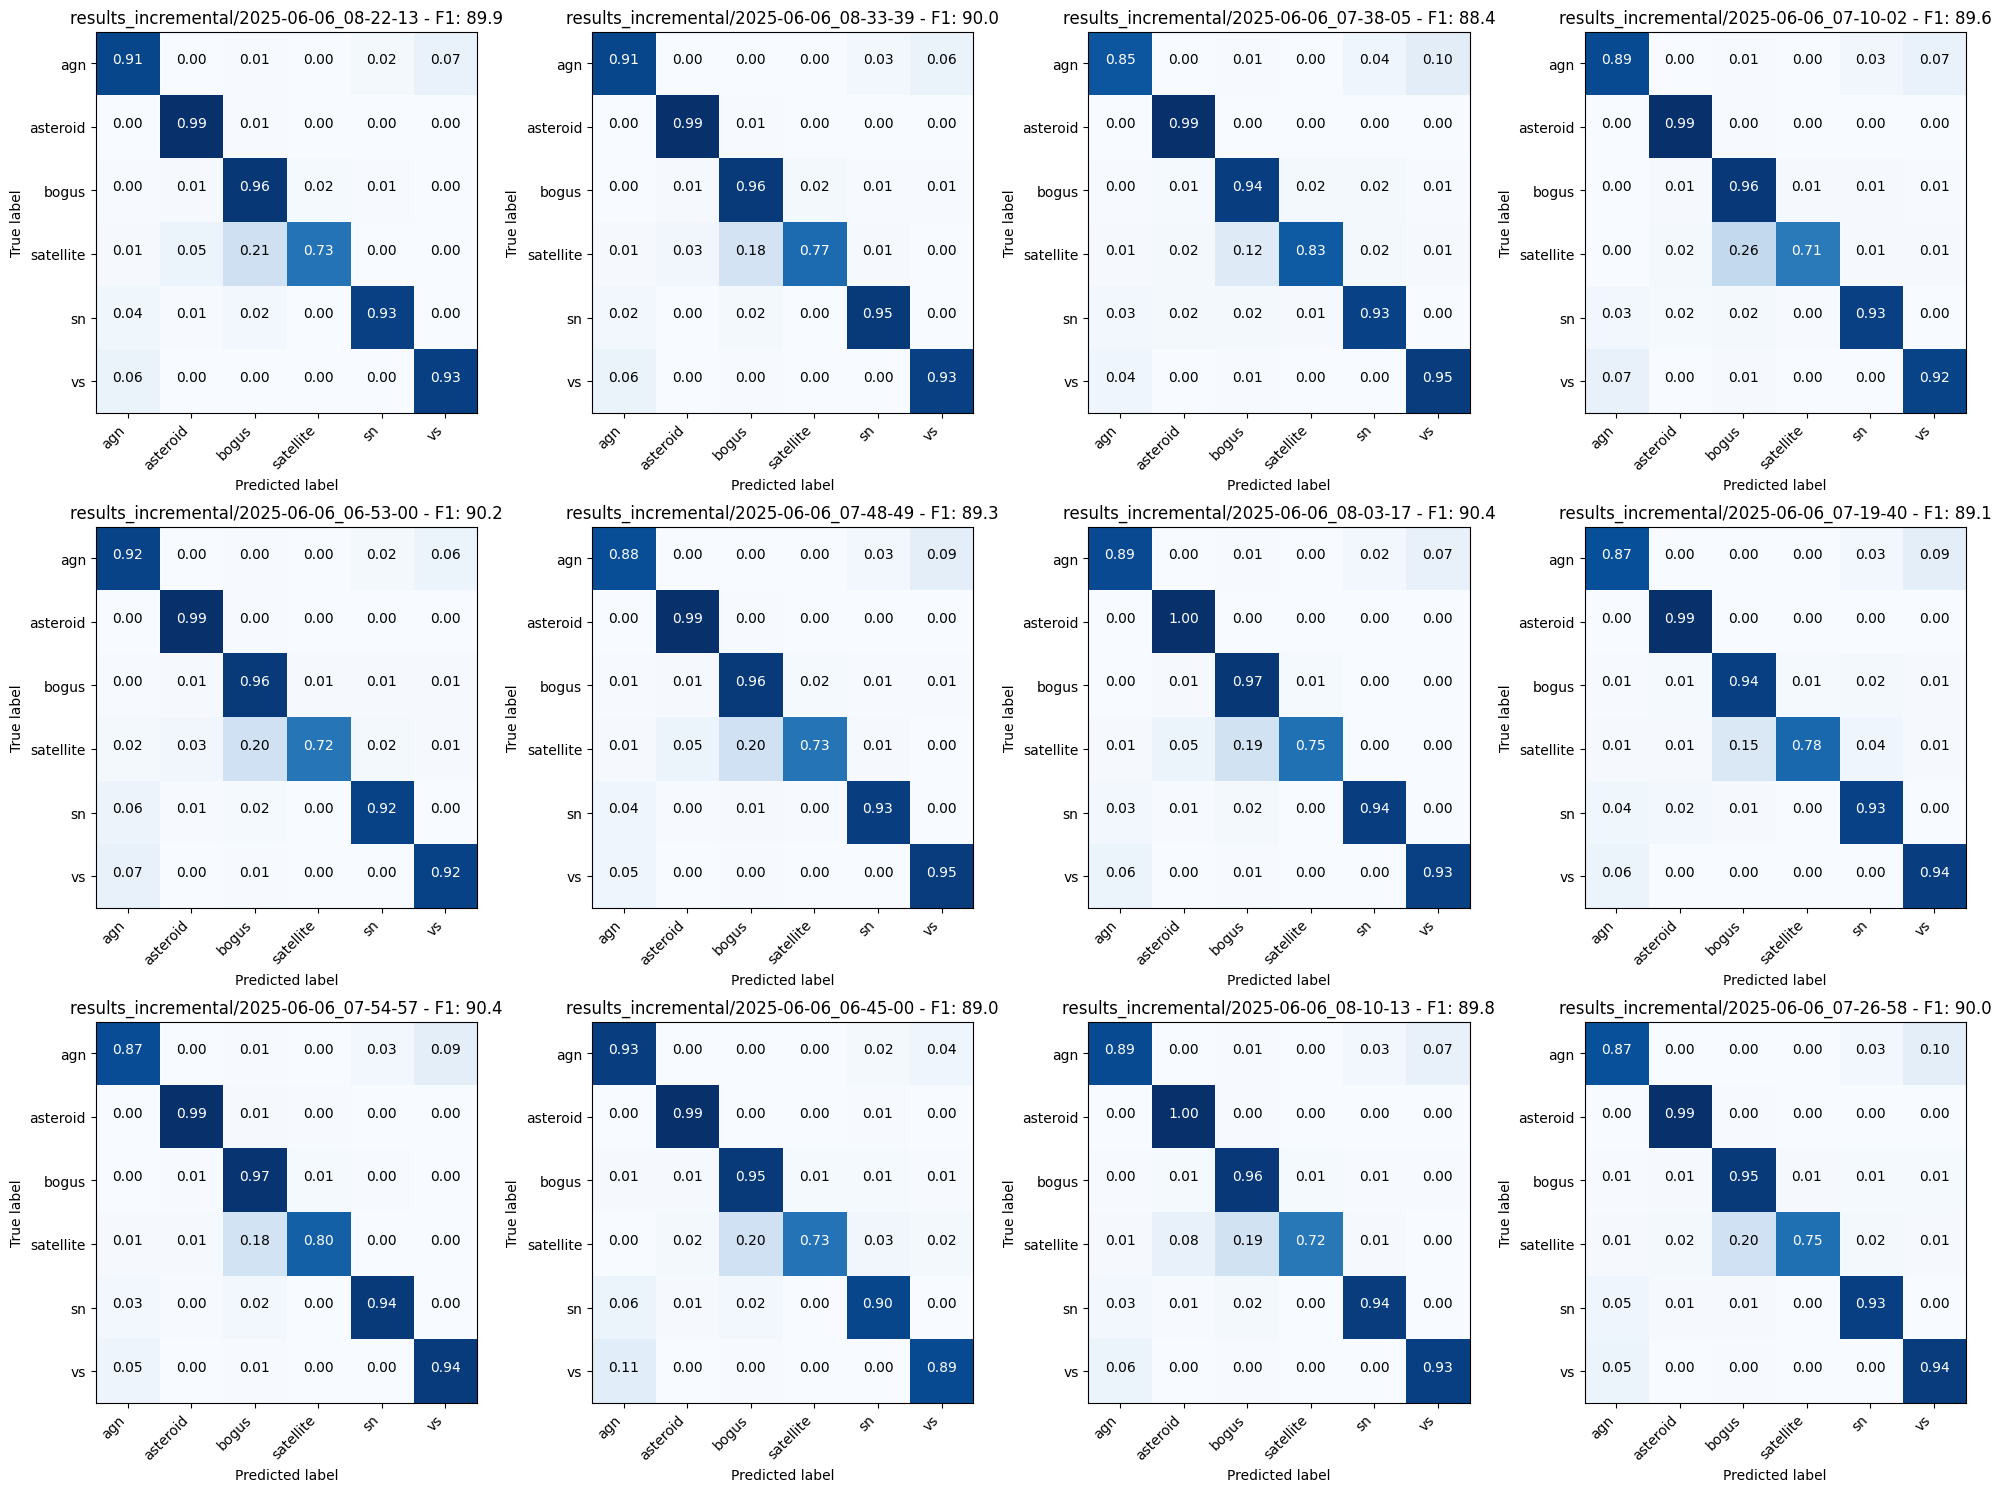

In [5]:
# Preparar los datos promediados
avg_conf_matrices = {}
avg_f1_scores = {}
class_names = None

for path_model in global_results:
    runs = global_results[path_model]
    print(f"\nProcessing model: {path_model} ({len(runs)} runs)")

    conf_matrices = []
    f1_scores = []

    for run_name in runs:
        conf = runs[run_name]['conf_matrix']
        conf_matrices.append(conf)

        # F1 macro
        f1 = runs[run_name]['classification_report']['macro avg']['f1-score']
        f1_scores.append(f1)

        # Guardar las clases (solo una vez)
        if class_names is None:
            class_names = runs[run_name]['classes']

    # Calcular promedio si hay varias runs
    if len(conf_matrices) > 1:
        avg_conf = np.mean(conf_matrices, axis=0)
    else:
        avg_conf = conf_matrices[0]

    avg_conf_matrices[path_model] = avg_conf

    # Calcular F1 promedio en porcentaje
    avg_f1 = np.mean(f1_scores) * 100  # convertir a porcentaje
    avg_f1_scores[path_model] = avg_f1

# -------------------------------
# GRAFICAR
# -------------------------------

# Parámetros de la figura
n_models = len(avg_conf_matrices)
n_cols = 4  # 🚀 4 matrices por fila
n_rows = int(np.ceil(n_models / n_cols))
figsize = (5 * n_cols, 5 * n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = axes.flatten()  # para iterarlo fácil

# Colormap
cmap = plt.cm.Blues

# Plot de cada modelo
for idx, (path_model, conf) in enumerate(avg_conf_matrices.items()):
    ax = axes[idx]
    im = ax.imshow(conf, interpolation='nearest', cmap=cmap)

    # Título con F1 en porcentaje (sin % y con 1 decimal)
    f1_score_display = f"{avg_f1_scores[path_model]:.1f}"
    ax.set_title(f"{path_model} - F1: {f1_score_display}", fontsize=12)

    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)

    # Mostrar valores en las celdas
    thresh = conf.max() / 2.
    for i in range(conf.shape[0]):
        for j in range(conf.shape[1]):
            ax.text(j, i, f"{conf[i, j]:.2f}",
                    horizontalalignment="center",
                    color="white" if conf[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# Si sobran subplots, los escondemos
for idx in range(len(avg_conf_matrices), len(axes)):
    axes[idx].axis('off')

# Ajustar layout
plt.tight_layout()
plt.show()


In [5]:
def evaluate_dataset(classifier, dataset):
    y_list = []
    predicted_probs_list = []
    images = []
    for X, pos, y in dataset:
        predicted_probs = tf.nn.softmax(classifier((X, pos)))
        y = y.numpy()
        y_list.append(y)
        predicted_probs_list.append(predicted_probs.numpy())
        images.append(X.numpy())
    predicted_probs = np.concatenate(predicted_probs_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    predictions = tf.argmax(predicted_probs, axis=1).numpy()
    return y, predicted_probs, predictions, images


path_models = [
    'results/2025-06-06_05-01-28',
    'results/2025-06-06_05-24-33'
]


normalized_ndarrays = pd.read_pickle(path_data)
LabelEncoder = normalized_ndarrays['label_encoder']
del normalized_ndarrays

N_CLASSES = 6
BATCH_SIZE = 64
LABELS = [
    'agn',
    'asteroid',
    'bogus',
    'satellite',
    'sn',
    'vs'
]

import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

dataset_name = 'full'
BATCH_SIZE = 32  # Ajusta según tu configuración

all_conf_matrices = []
all_class_reports = []

for i in range(5):  # Para las 5 corridas
   with tf.device('/cpu:0'):
      training_dataset, testidation_dataset, test_dataset, dict_info_model = get_tf_datasets(batch_size=BATCH_SIZE, use_metadata=True, use_only_avro=False)
      
      ## POSITION
      stamp_classifier = tf.keras.models.load_model(f'results/2025-06-05_16-15-28/run_{i}/model.keras')

      # Obtener predicciones
      y_test, test_predicted_probs, test_predictions, images_test = evaluate_dataset(stamp_classifier, test_dataset)

      y_test_labels = LabelEncoder.inverse_transform(y_test)
      test_predictions_labels = LabelEncoder.inverse_transform(test_predictions)

      # Calcular la matriz de confusión
      conf_matrix = confusion_matrix(y_test_labels, test_predictions_labels, labels=LabelEncoder.classes_, normalize='true')
      all_conf_matrices.append(conf_matrix)

      # Calcular el classification report
      report = classification_report(y_test_labels, test_predictions_labels, output_dict=True)
      all_class_reports.append(report)

{'x_train': array([[[[ 1.31217912e-01,  2.08907306e-01, -1.01644330e-01,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 2.04098701e-01,  2.16876030e-01, -3.88859846e-02,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 1.58876374e-01,  2.10589081e-01, -3.21847685e-02,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            1.00000000e+00,  1.00000000e+00,  1.00000000e+00]],
 
         [[ 1.27885818e-01,  1.91337809e-01, -1.43070174e-02,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 1.99794412e-01,  1.99527159e-01,  5.73619045e-02,
            0.00000000e+00,  0.000

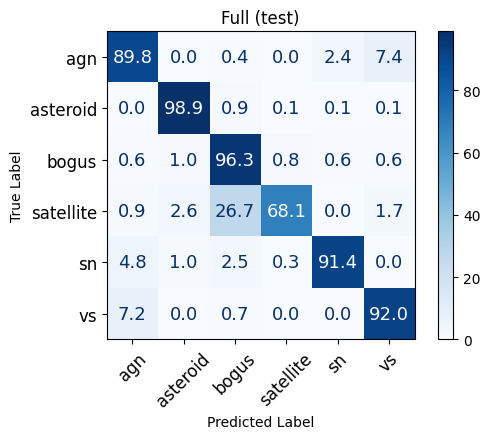

In [19]:
## CON POS
mean_conf_matrix = np.mean(all_conf_matrices, axis=0) * 100

# **2. Graficar la matriz de confusión promedio**
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix, display_labels=LabelEncoder.classes_,)
disp.plot(ax=ax, cmap="Blues", values_format=".1f")

# Ajustes de etiquetas y títulos
plt.xticks(rotation=45, fontsize=12)  # Rotar el eje X
plt.yticks(fontsize=12)  # Aumentar el tamaño en el eje Y
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Full (test)")

# Ajuste del tamaño del texto dentro de la matriz
for text in ax.texts:
    text.set_fontsize(13)  # Aumentar tamaño de los valores en la matriz
plt.show()

In [20]:
# **3. Calcular la media y desviación estándar del classification report**
labels = list(all_class_reports[0].keys())[:-3]  # Excluye 'accuracy', 'macro avg' y 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

# Crear DataFrame para almacenar resultados
report_df = pd.DataFrame(index=labels, columns=[f'{m}_mean' for m in metrics] + [f'{m}_std' for m in metrics])

# Calcular media y desviación estándar para cada métrica
for label in labels:
    for metric in metrics:
        values = [rep[label][metric] for rep in all_class_reports]
        report_df.at[label, f'{metric}_mean'] = np.mean(values)
        report_df.at[label, f'{metric}_std'] = np.std(values)

report_df*100

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
agn,89.63757,89.820972,89.729177,0.0,0.0,0.0
asteroid,97.792138,98.910675,98.348226,0.0,0.0,0.0
bogus,97.216071,96.332288,96.772162,0.0,0.0,0.0
satellite,71.818182,68.103448,69.911504,0.0,0.0,0.0
sn,90.547945,91.42462,90.984171,0.0,0.0,0.0
vs,91.833741,91.968658,91.90115,0.0,0.0,0.0


In [21]:
# Extraer las métricas macro promedio y su desviación estándar
macro_metrics = ['macro avg']  # Puedes agregar 'weighted avg' si lo necesitas

# Crear DataFrame para los macro promedios
macro_report_df = pd.DataFrame(index=macro_metrics, columns=[f'{m}_mean' for m in ['precision', 'recall', 'f1-score']] +
                                                            [f'{m}_std' for m in ['precision', 'recall', 'f1-score']])

# Calcular media y desviación estándar para los macros
for metric in ['precision', 'recall', 'f1-score']:
    values = [rep['macro avg'][metric] for rep in all_class_reports]
    macro_report_df.at['macro avg', f'{metric}_mean'] = np.mean(values) * 100
    macro_report_df.at['macro avg', f'{metric}_std'] = np.std(values) * 100

macro_report_df

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
macro avg,89.807608,89.426777,89.607732,0.0,0.0,0.0


In [22]:
print('******* Test Set *******')
print(f"F1: {macro_report_df[f'f1-score_mean'].values[0]:.2f} ± {macro_report_df[f'f1-score_std'].values[0]:.2f}") 
print(f"Precision: {macro_report_df[f'precision_mean'].values[0]:.2f} ± {macro_report_df[f'precision_std'].values[0]:.2f}") 
print(f"Recall: {macro_report_df[f'recall_mean'].values[0]:.2f} ± {macro_report_df[f'recall_std'].values[0]:.2f}") 
print('************************')

******* Test Set *******
F1: 89.61 ± 0.00
Precision: 89.81 ± 0.00
Recall: 89.43 ± 0.00
************************


In [23]:
f1_test_paper = 86.68
prec_test_paper = 84.34
recall_test_paper = 90.48

macro_report_df[f'f1-score_mean'].values[0] - f1_test_paper

np.float64(2.927731774100195)

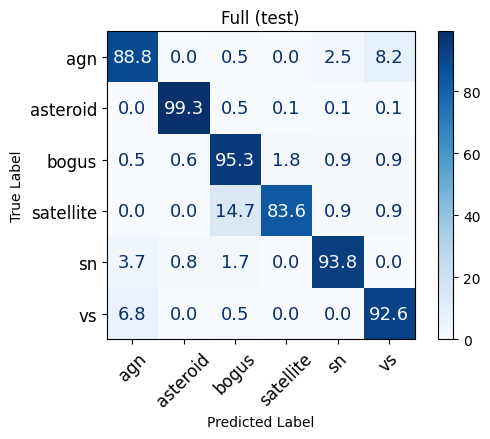

In [23]:
## CON METADATOS
mean_conf_matrix = np.mean(all_conf_matrices, axis=0) * 100

# **2. Graficar la matriz de confusión promedio**
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix, display_labels=LabelEncoder.classes_,)
disp.plot(ax=ax, cmap="Blues", values_format=".1f")

# Ajustes de etiquetas y títulos
plt.xticks(rotation=45, fontsize=12)  # Rotar el eje X
plt.yticks(fontsize=12)  # Aumentar el tamaño en el eje Y
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Full (test)")

# Ajuste del tamaño del texto dentro de la matriz
for text in ax.texts:
    text.set_fontsize(13)  # Aumentar tamaño de los valores en la matriz
plt.show()

In [24]:
# **3. Calcular la media y desviación estándar del classification report**
labels = list(all_class_reports[0].keys())[:-3]  # Excluye 'accuracy', 'macro avg' y 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

# Crear DataFrame para almacenar resultados
report_df = pd.DataFrame(index=labels, columns=[f'{m}_mean' for m in metrics] + [f'{m}_std' for m in metrics])

# Calcular media y desviación estándar para cada métrica
for label in labels:
    for metric in metrics:
        values = [rep[label][metric] for rep in all_class_reports]
        report_df.at[label, f'{metric}_mean'] = np.mean(values)
        report_df.at[label, f'{metric}_std'] = np.std(values)

report_df*100

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
agn,90.46875,88.849105,89.651613,0.0,0.0,0.0
asteroid,98.647186,99.291939,98.968512,0.0,0.0,0.0
bogus,98.158915,95.266458,96.691059,0.0,0.0,0.0
satellite,62.580645,83.62069,71.586716,0.0,0.0,0.0
sn,89.328063,93.775934,91.497976,0.0,0.0,0.0
vs,90.738964,92.605289,91.662627,0.0,0.0,0.0


In [25]:
# Extraer las métricas macro promedio y su desviación estándar
macro_metrics = ['macro avg']  # Puedes agregar 'weighted avg' si lo necesitas

# Crear DataFrame para los macro promedios
macro_report_df = pd.DataFrame(index=macro_metrics, columns=[f'{m}_mean' for m in ['precision', 'recall', 'f1-score']] +
                                                            [f'{m}_std' for m in ['precision', 'recall', 'f1-score']])

# Calcular media y desviación estándar para los macros
for metric in ['precision', 'recall', 'f1-score']:
    values = [rep['macro avg'][metric] for rep in all_class_reports]
    macro_report_df.at['macro avg', f'{metric}_mean'] = np.mean(values) * 100
    macro_report_df.at['macro avg', f'{metric}_std'] = np.std(values) * 100

macro_report_df

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
macro avg,88.32042,92.234902,90.009751,0.0,0.0,0.0


In [26]:
print('******* Test Set *******')
print(f"F1: {macro_report_df[f'f1-score_mean'].values[0]:.2f} ± {macro_report_df[f'f1-score_std'].values[0]:.2f}") 
print(f"Precision: {macro_report_df[f'precision_mean'].values[0]:.2f} ± {macro_report_df[f'precision_std'].values[0]:.2f}") 
print(f"Recall: {macro_report_df[f'recall_mean'].values[0]:.2f} ± {macro_report_df[f'recall_std'].values[0]:.2f}") 
print('************************')

******* Test Set *******
F1: 90.01 ± 0.00
Precision: 88.32 ± 0.00
Recall: 92.23 ± 0.00
************************


In [27]:
f1_test_paper = 86.68
prec_test_paper = 84.34
recall_test_paper = 90.48

macro_report_df[f'f1-score_mean'].values[0] - f1_test_paper

np.float64(3.329750617415101)

0.19372195662717218

In [38]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

dataset_name = 'full'
BATCH_SIZE = 32  # Ajusta según tu configuración

all_conf_matrices = []
all_class_reports = []

for i in range(5):  # Para las 5 corridas
    with tf.device('/cpu:0'):
        training_dataset, validation_dataset, test_dataset, label_encoder = get_tf_datasets(
            dataset_name=dataset_name, batch_size=BATCH_SIZE)
        
        # Cargar el modelo entrenado para la corrida i
        stamp_classifier = tf.keras.models.load_model(f'{dataset_name}_run_{i}/')

        # Obtener predicciones
        y_val, val_predicted_probs, val_predictions, images_val = evaluate_dataset(stamp_classifier, validation_dataset)

        y_val_labels = LabelEncoder.inverse_transform(y_val)
        val_predictions_labels = LabelEncoder.inverse_transform(val_predictions)

        # Calcular la matriz de confusión
        conf_matrix = confusion_matrix(y_val_labels, val_predictions_labels, labels=LabelEncoder.classes_, normalize='true')
        all_conf_matrices.append(conf_matrix)

        # Calcular el classification report
        report = classification_report(y_val_labels, val_predictions_labels, output_dict=True)
        all_class_reports.append(report)

x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:41:31.357988: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:41:41.030626: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:41:52.047254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:42:01.458283: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_1/Assert/AssertGuard/branch_executed/_47


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:42:12.153323: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_2/Assert/AssertGuard/branch_executed/_66
2025-02-07 08:42:21.494043: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_1/Assert/AssertGuard/branch_executed/_47


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:42:32.456927: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:42:41.868318: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:42:52.767949: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:43:02.335785: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


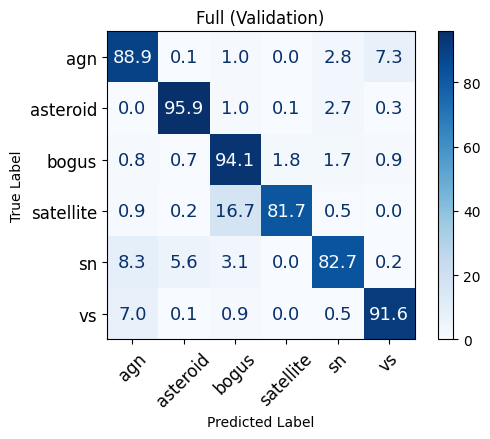

In [45]:
mean_conf_matrix = np.mean(all_conf_matrices, axis=0) * 100

# **2. Graficar la matriz de confusión promedio**
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix, display_labels=LabelEncoder.classes_,)
disp.plot(ax=ax, cmap="Blues", values_format=".1f")

# Ajustes de etiquetas y títulos
plt.xticks(rotation=45, fontsize=12)  # Rotar el eje X
plt.yticks(fontsize=12)  # Aumentar el tamaño en el eje Y
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Full (Validation)")

# Ajuste del tamaño del texto dentro de la matriz
for text in ax.texts:
    text.set_fontsize(13)  # Aumentar tamaño de los valores en la matriz
plt.show()

In [40]:
# **3. Calcular la media y desviación estándar del classification report**
labels = list(all_class_reports[0].keys())[:-3]  # Excluye 'accuracy', 'macro avg' y 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

# Crear DataFrame para almacenar resultados
report_df = pd.DataFrame(index=labels, columns=[f'{m}_mean' for m in metrics] + [f'{m}_std' for m in metrics])

# Calcular media y desviación estándar para cada métrica
for label in labels:
    for metric in metrics:
        values = [rep[label][metric] for rep in all_class_reports]
        report_df.at[label, f'{metric}_mean'] = np.mean(values)
        report_df.at[label, f'{metric}_std'] = np.std(values)

report_df*100

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
agn,88.270347,88.890026,88.545391,1.268922,2.239778,0.558263
asteroid,96.461751,95.893246,96.167177,0.698752,1.376865,0.540942
bogus,96.868027,94.087774,95.452292,0.765394,0.704765,0.166169
satellite,61.871745,81.724138,70.31949,2.09429,4.021346,0.987691
sn,78.379359,82.710927,80.36352,3.885095,2.547356,1.231768
vs,91.360904,91.576885,91.43387,1.795535,1.807045,0.224377


In [42]:
# Extraer las métricas macro promedio y su desviación estándar
macro_metrics = ['macro avg']  # Puedes agregar 'weighted avg' si lo necesitas

# Crear DataFrame para los macro promedios
macro_report_df = pd.DataFrame(index=macro_metrics, columns=[f'{m}_mean' for m in ['precision', 'recall', 'f1-score']] +
                                                            [f'{m}_std' for m in ['precision', 'recall', 'f1-score']])

# Calcular media y desviación estándar para los macros
for metric in ['precision', 'recall', 'f1-score']:
    values = [rep['macro avg'][metric] for rep in all_class_reports]
    macro_report_df.at['macro avg', f'{metric}_mean'] = np.mean(values) * 100
    macro_report_df.at['macro avg', f'{metric}_std'] = np.std(values) * 100

macro_report_df

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
macro avg,85.535356,89.147166,87.046957,0.512067,0.593025,0.254697


In [43]:
print('******* Validation Set *******')
print(f"F1: {macro_report_df[f'f1-score_mean'].values[0]:.2f} ± {macro_report_df[f'f1-score_std'].values[0]:.2f}") 
print(f"Precision: {macro_report_df[f'precision_mean'].values[0]:.2f} ± {macro_report_df[f'precision_std'].values[0]:.2f}") 
print(f"Recall: {macro_report_df[f'recall_mean'].values[0]:.2f} ± {macro_report_df[f'recall_std'].values[0]:.2f}") 
print('************************')

******* Validation Set *******
F1: 87.05 ± 0.25
Precision: 85.54 ± 0.51
Recall: 89.15 ± 0.59
************************


In [ ]:
mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(figsize, figsize)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_xlabel('Predicted Label', fontsize=fs+2)
ax.set_ylabel('True Label', fontsize=fs+2)

ax.xaxis.label.set_size(fs+2)
ax.yaxis.label.set_size(fs+2)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.savefig(path_save)
plt.close(fig)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Mean Confusion Matrix Over 5 Runs")
plt.show()

In [18]:
dataset_name = 'full'
i = 0

with tf.device('/cpu:0'):
    training_dataset, validation_dataset, test_dataset, label_encoder = get_tf_datasets(
        dataset_name=dataset_name, batch_size=BATCH_SIZE)
    #stamp_classifier = tf.keras.models.load_model(f'saved_models/{dataset_name}_run_{i}/')
    stamp_classifier = tf.keras.models.load_model(f'{dataset_name}_run_{i}/')
    y_val, val_predicted_probs, val_predictions, images_val = evaluate_dataset(stamp_classifier, validation_dataset)

print('y_val:', y_val.shape)
print('val_predictions:', val_predictions.shape)

(9862,)

In [14]:
with tf.device('/cpu:0'):
    y_test, test_predicted_probs, test_predictions, images_test = evaluate_dataset(stamp_classifier, test_dataset)

In [ ]:
print('y_test:', y_test.shape)
print('test_predictions:', test_predictions.shape)

In [45]:
for b in validation_dataset:
    print(b)
    break

(<tf.Tensor: shape=(64, 63, 63, 6), dtype=float32, numpy=
array([[[[ 5.55989780e-02,  2.77429610e-01, -3.79745066e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 9.00271088e-02,  2.71785200e-01,  1.48523405e-01,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 6.00318424e-02,  2.72807121e-01,  2.99650021e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 6.52558804e-02,  2.78823227e-01,  6.73804358e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.78682733e-02,  2.81814069e-01,  2.02923119e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.18669274e-02,  2.79148817e-01,  1.14476290e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 6.76989928e-02,  2.76165426e-01,  6.55059516e-03,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.14817338e-02,  2.77233958e-01, -1.95179328e-01,
    

In [35]:
satellite_cands = images[val_predicted_probs[:, 3] > 0.8]

In [25]:
images = np.concatenate(images, axis=0)
images.shape

(9862, 63, 63, 6)

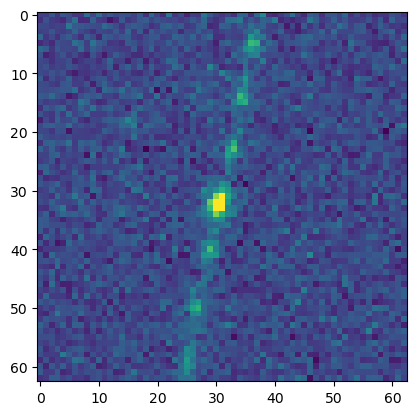

In [44]:
plt.imshow(satellite_cands[8, :, :, 0])